## Imports and Initialization

In [1]:
#!pip install sympy==1.12 --force-reinstall

In [2]:
#import torchvision
#print(torchvision.__version__)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Prep

In [5]:
data_prefix = './datasets'

In [6]:
NUM_TRAIN = 49000
transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar100_train = datasets.CIFAR100(data_prefix, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar100_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = datasets.CIFAR100(data_prefix, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = datasets.CIFAR100(data_prefix, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=64)

100%|██████████| 169M/169M [00:03<00:00, 55.2MB/s]


In [7]:
cifar100_train[0][0].shape

torch.Size([3, 32, 32])

## CNN Model

In [8]:
# RegDeepCNN(channels_list, pool_list)
# Flexible CNN with variable conv layers and optional 2x2 max pooling per layer.
# Args:
#  - channels_list (list of int): output channels per conv layer.
#  - pool_list (list of bool): whether to apply max pooling after each conv.
# Constraints:
#  - Input: 32x32 RGB images.
#  - Max pooling auto-disabled if it reduces spatial size below 4x4.
#  - channels_list and pool_list must be same length.
#  - Max 3 poolings allowed to keep spatial size ≥4x4.
# Example:
#  channels = [32,32,64,64]; pools = [False,True,False,True]
#  model = RegDeepCNN(channels, pools)
#  output = model(torch.randn(1,3,32,32))

In [9]:
class RegDeepCNN(nn.Module):
    def __init__(self, channels_list, pool_list):
        super(RegDeepCNN, self).__init__()

        assert len(channels_list) == len(pool_list), "channels_list and pool_list must be the same length"
        assert sum(pool_list) <= 3, "Too many poolings; spatial size < 4x4"

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.pool_bools = pool_list
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels = 3  # input RGB images

        for out_channels in channels_list:
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.bns.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels

        # After conv layers, define a linear layer.
        # To calculate the input size for linear layer, you need to know the spatial size after conv+pool layers.
        # For example, assuming input 32x32 and each maxpool halves size:
        num_pools = sum(pool_list)
        final_spatial_size = 32 // (2 ** num_pools)
        final_channels = channels_list[-1]
        self.fc1 = nn.Linear(final_channels * final_spatial_size * final_spatial_size, 512)
        self.fc2 = nn.Linear(512,100)

    def forward(self, x):
        for conv, bn, do_pool in zip(self.convs, self.bns, self.pool_bools):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)
            if do_pool:
                x = self.pool(x)

        x = F.dropout(x, p=0.5)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        return x


## Training

In [10]:
from tqdm import tqdm

### Accuracy and Loss Calculation Func

In [11]:
def check_accuracy_and_loss(loader, model, device):
    acc = 0
    total_loss = 0
    model.eval()
    num_correct = 0
    num_samples = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)
            total_loss += loss
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = num_correct / num_samples
    total_loss /= len(loader)
    return acc, total_loss

### Training func

In [12]:
def train_model(model, loader_train, loader_val, optimizer, criterion, epochs, device):
    best_val_loss = float('inf')
    best_model_wts = None

    model.to(device)

    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0  # Accumulate loss for display
        epoch_steps = 0  # Count steps for loss averaging

        # Progress bar for training batches
        with tqdm(total=len(loader_train), desc=f"Training Epoch {epoch + 1}") as pbar:
            for x, y in loader_train:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                scores = model(x)
                loss = criterion(scores, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress
                epoch_loss += loss.item()
                epoch_steps += 1
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)

        train_acc, train_loss = check_accuracy_and_loss(loader_train, model, device=DEVICE)
        val_acc, val_loss = check_accuracy_and_loss(loader_val, model, device=DEVICE)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    # returning best and final model
    final_model_wts = model.state_dict().copy()  # save final weights
    model.load_state_dict(best_model_wts)       # load best weights
    return best_model_wts, final_model_wts, train_accs, val_accs, train_losses, val_losses

### Testing different architecture and hyperparameter configs

In [13]:
import os
output_dir = "/kaggle/working"

lr = 1e-3
epochs = 1

configs = [
    # deeper network, max allowed pooling
    {'name': 'model-1', 'channels': [64, 128, 256, 256], 'pools': [False, True, True, True]},
    # deeper network, max allowed pooling
    {'name': 'model-2','channels': [64, 128, 256, 256], 'pools': [False, True, False, True]},
    # deeper network, max allowed pooling
    {'name': 'model-3','channels': [64, 128, 128, 256], 'pools': [False, True, False, True]},
    # deeper network, max allowed pooling
    {'name': 'model-4','channels': [64, 64, 128, 128, 256], 'pools': [False, True, False, True, False]}
]

results = []

for mc in configs:
    print(f"\nTraining model with channels={mc['channels']}, pools={mc['pools']}")

    model = RegDeepCNN(mc['channels'], mc['pools'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Adjust train_model to return best and final weights plus metrics
    best_wts, final_wts, train_accs, val_accs, train_losses, val_losses = train_model(
        model, loader_train, loader_val, optimizer, criterion, epochs=epochs, device=DEVICE)

    best_path = os.path.join(output_dir, f"model_{mc['name']}_best.pth")
    final_path = os.path.join(output_dir, f"model_{mc['name']}_final.pth")
    
    torch.save(best_wts, best_path)
    torch.save(final_wts, final_path)

    results.append({
        'name': mc['name'],
        'channels': mc['channels'],
        'pools': mc['pools'],
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_weights': best_wts,
        'final_weights': final_wts,
    })


Training model with channels=[64, 128, 256, 256], pools=[False, True, True, True]
Epoch 1/1


Training Epoch 1: 100%|██████████| 766/766 [00:25<00:00, 30.33it/s, Batch Loss=3.05]


Epoch 1 - Train Loss: 3.1535, Train Acc: 22.64%, Val Loss: 3.2563, Val Acc: 20.80%

Training model with channels=[64, 128, 256, 256], pools=[False, True, False, True]
Epoch 1/1


Training Epoch 1: 100%|██████████| 766/766 [00:27<00:00, 27.47it/s, Batch Loss=3.91]


Epoch 1 - Train Loss: 3.3118, Train Acc: 20.17%, Val Loss: 3.3679, Val Acc: 18.50%

Training model with channels=[64, 128, 128, 256], pools=[False, True, False, True]
Epoch 1/1


Training Epoch 1: 100%|██████████| 766/766 [00:25<00:00, 30.11it/s, Batch Loss=3.19]


Epoch 1 - Train Loss: 3.3134, Train Acc: 19.46%, Val Loss: 3.3552, Val Acc: 19.40%

Training model with channels=[64, 64, 128, 128, 256], pools=[False, True, False, True, False]
Epoch 1/1


Training Epoch 1: 100%|██████████| 766/766 [00:22<00:00, 34.77it/s, Batch Loss=3.16]


Epoch 1 - Train Loss: 3.0772, Train Acc: 24.65%, Val Loss: 3.1951, Val Acc: 22.20%


In [14]:
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for r in results:
        label = f"C: {r['name']}"
        train_losses = [l.item() if torch.is_tensor(l) else l for l in r['train_losses']]
        val_losses = [l.item() if torch.is_tensor(l) else l for l in r['val_losses']]
        plt.plot(train_losses, label=f"{label} - Train")
        plt.plot(val_losses, linestyle='--', label=f"{label} - Val")
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plt.figure(figsize=(10, 6))
    for r in results:
        label = f"C: {r['name']}"
        train_accs = [a.item() if torch.is_tensor(a) else a for a in r['train_accs']]
        val_accs = [a.item() if torch.is_tensor(a) else a for a in r['val_accs']]
        plt.plot(train_accs, label=f"{label} - Train")
        plt.plot(val_accs, linestyle='--', label=f"{label} - Val")
    plt.title("Accuracies")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [15]:
def evaluate_best_models(results, loader_train, loader_val, loader_test, device):
    print("=== Final Evaluation with Best Weights ===")
    for r in results:
        model = RegDeepCNN(r['channels'], r['pools']).to(device)
        model.load_state_dict(r['best_weights'])

        train_acc, _ = check_accuracy_and_loss(loader_train, model, device)
        val_acc, _ = check_accuracy_and_loss(loader_val, model, device)
        test_acc, _ = check_accuracy_and_loss(loader_test, model, device)

        print(f"Channels: {r['channels']}, Pools: {r['pools']}")
        print(f"  Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Test Acc: {test_acc:.2%}\n")


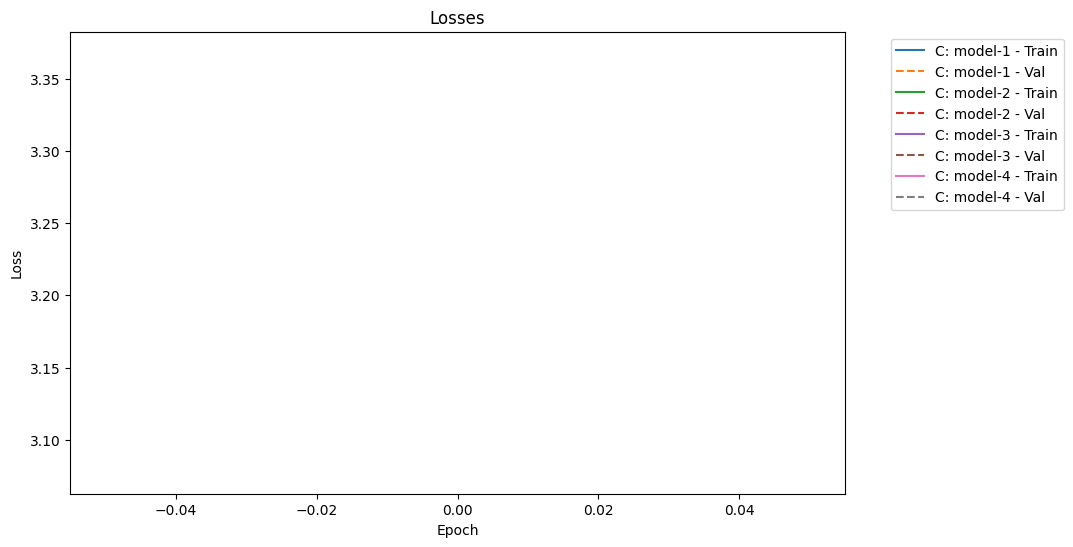

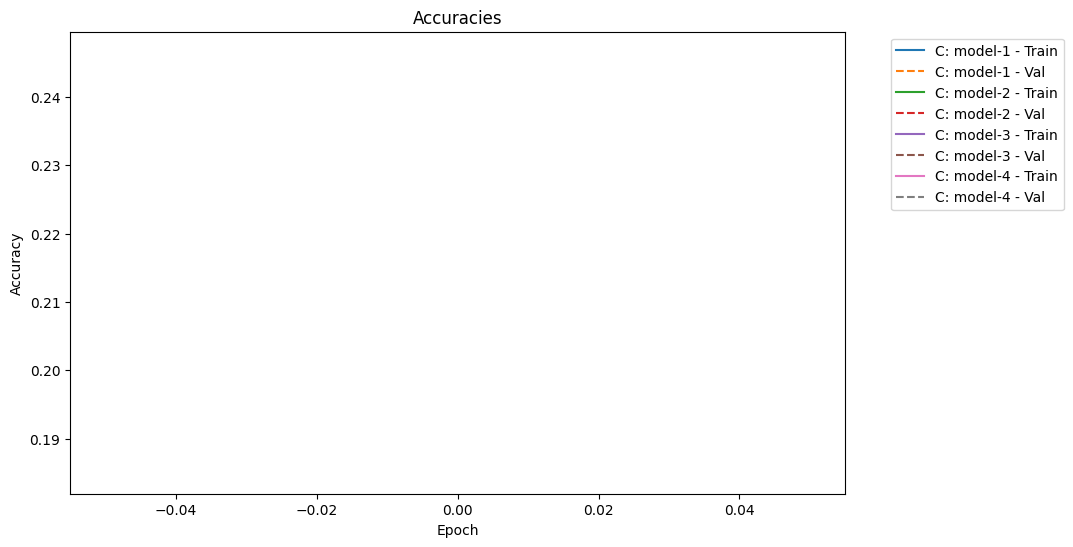

=== Final Evaluation with Best Weights ===
Channels: [64, 128, 256, 256], Pools: [False, True, True, True]
  Train Acc: 22.70%, Val Acc: 21.10%, Test Acc: 22.16%

Channels: [64, 128, 256, 256], Pools: [False, True, False, True]
  Train Acc: 20.12%, Val Acc: 18.10%, Test Acc: 18.77%

Channels: [64, 128, 128, 256], Pools: [False, True, False, True]
  Train Acc: 19.12%, Val Acc: 19.20%, Test Acc: 19.12%

Channels: [64, 64, 128, 128, 256], Pools: [False, True, False, True, False]
  Train Acc: 24.61%, Val Acc: 23.00%, Test Acc: 22.98%



In [16]:
plot_results(results)
evaluate_best_models(results, loader_train, loader_val, loader_test, DEVICE)

In [17]:
import pandas as pd

# Create DataFrame with selected columns
summary_df = pd.DataFrame([
    {
        'Model Name': r['name'],
        'Channels': r['channels'],
        'Pools': r['pools']
    }
    for r in results
])

# Display as a table
print(summary_df.to_string(index=False))


Model Name                Channels                             Pools
   model-1     [64, 128, 256, 256]         [False, True, True, True]
   model-2     [64, 128, 256, 256]        [False, True, False, True]
   model-3     [64, 128, 128, 256]        [False, True, False, True]
   model-4 [64, 64, 128, 128, 256] [False, True, False, True, False]
